In [12]:
#   #For working in Colab:

# !pip install cfbd      
# # !pip install requests

In [13]:
# import requests

# url = 'https://raw.githubusercontent.com/dyeds/PIC-16B-Project/main/DataFunctions.py'
# r=requests.get(url)

# with open('DataFunctions.py', 'w') as f:  
#     f.write(r.text)

In [14]:
import cfbd
from cfbd.rest import ApiException
from pprint import pprint
import pandas as pd
import sqlite3
import urllib.request
import json
import DataFunctions
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import networkx as nx

configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '3WCU5V2X05Rvh60ZxUG8FarJN4s2D1lcd2c2r6Kz/qL1Y3tVBJtWsuNATnzHRV2h'
configuration.api_key_prefix['Authorization'] = 'Bearer'

## Data Preprocessing

Games DF

In [15]:
api_instance = cfbd.GamesApi(cfbd.ApiClient(configuration))
year=2022
division="fbs"

# no longer need, right?
# try:
#     api_response = api_instance.get_games(year=year,division=division)
#     print(len(api_response))
# except:
#     print(ApiException)
    

In [16]:
gamelist = DataFunctions.get_fbs_games(api_instance=api_instance,year=2022)
# len(gamelist)

In [17]:
games_df = DataFunctions.df_from_games(gamelist=gamelist)
# games_df.head()

In [18]:
# conn = sqlite3.connect("CollegeFootball.db")
# games_df.to_sql("games",conn,if_exists="replace",index=False)
# conn.close()


In [19]:
# we can see with this code that we can extract DF from SQL db

# conn = sqlite3.connect("CollegeFootball.db")
# trialdf = pd.read_sql_query("SELECT * FROM games",conn)
# conn.close()
# print(trialdf.shape)
# trialdf.head()


Betting lines DF

In [20]:
api_instance1 = cfbd.BettingApi(cfbd.ApiClient(configuration))

In [21]:
conferences=[]
for game in gamelist:
    conferences.append(game.away_conference)
conferences=set(conferences)

conferences

{'ACC',
 'American Athletic',
 'Big 12',
 'Big Ten',
 'Conference USA',
 'FBS Independents',
 'Mid-American',
 'Mountain West',
 'Pac-12',
 'SEC',
 'Sun Belt'}

In [22]:
betting_list=DataFunctions.get_fbs_betting(api_instance=api_instance1,year=2022,conferences=conferences)

In [23]:
betting_df=DataFunctions.df_betting_lines(betting_list)
betting_df

#warning seems to be since betting line -0.0 for one of the games but still stores value as 0 so should be fine

,id,av_spread,av_total
0,401411101,-24.375,51.375
1,401404079,7.125,65.625
2,401403893,1.500,51.000
3,401404080,2.500,45.000
4,401404081,13.625,53.000
...,...,...,...
733,401403935,12.500,50.500
734,401404029,21.125,61.125
735,401416641,-2.750,55.750
736,401404036,11.500,47.000


In [24]:
# conn=sqlite3.connect("CollegeFootball.db")
# betting_df.to_sql("betting_lines",conn,if_exists="replace",index=False)
# conn.close()

In [25]:
# #sample merge dataframe

# cmd=\
# """
# SELECT G.away_team,G.away_points,G.home_points,G.home_team,B.av_spread,B.av_total
# FROM games G
# INNER JOIN betting_lines B ON G.id=B.id
# """
# conn=sqlite3.connect("CollegeFootball.db")
# test_merge=pd.read_sql_query(cmd,conn)
# conn.close() # do not forget this after query
# test_merge

Team stats per season DF

In [26]:
api_instance2 = cfbd.StatsApi(cfbd.ApiClient(configuration))

In [27]:
teamstats = api_instance2.get_advanced_team_season_stats(year=year)

In [28]:
stats_df = DataFunctions.df_team_advstats(teamstats=teamstats)

In [29]:
stats_df.columns

Index(['team', 'season', 'conference', 'Offensive_plays', 'Offensive_drives',
       'Offensive_ppa', 'Offensive_total_ppa', 'Offensive_success_rate',
       'Offensive_explosiveness', 'Offensive_power_success',
       'Offensive_stuff_rate', 'Offensive_line_yards',
       'Offensive_line_yards_total', 'Offensive_second_level_yards',
       'Offensive_second_level_yards_total', 'Offensive_open_field_yards',
       'Offensive_open_field_yards_total', 'Offensive_total_opportunies',
       'Offensive_points_per_opportunity', 'Defensive_plays',
       'Defensive_drives', 'Defensive_ppa', 'Defensive_total_ppa',
       'Defensive_success_rate', 'Defensive_explosiveness',
       'Defensive_power_success', 'Defensive_stuff_rate',
       'Defensive_line_yards', 'Defensive_line_yards_total',
       'Defensive_second_level_yards', 'Defensive_second_level_yards_total',
       'Defensive_open_field_yards', 'Defensive_open_field_yards_total',
       'Defensive_total_opportunies', 'Defensive_points_p

In [30]:
cols = ['team','season','conference','Offensive_ppa','Offensive_success_rate',
        'Offensive_explosiveness','Offensive_power_success',
        'Offensive_stuff_rate','Offensive_line_yards',
        'Defensive_ppa','Defensive_success_rate',
        'Defensive_explosiveness','Defensive_power_success',
        'Defensive_stuff_rate','Defensive_line_yards',
        'Offensive_havoc_total','Offensive_rushing_plays_ppa',
        'Offensive_rushing_plays_success_rate',
        'Offensive_rushing_plays_explosiveness',
        'Offensive_passing_plays_ppa',
        'Offensive_passing_plays_success_rate',
        'Offensive_passing_plays_explosiveness',
        'Defensive_havoc_total','Defensive_rushing_plays_ppa',
        'Defensive_rushing_plays_success_rate',
        'Defensive_rushing_plays_explosiveness',
        'Defensive_passing_plays_ppa',
        'Defensive_passing_plays_success_rate',
        'Defensive_passing_plays_explosiveness']
stats_df1 = DataFunctions.df_stats_needed(stats_df,cols)

In [31]:
stats_df1.shape

(133, 29)

In [32]:
# We use this to insert api_responses to SQL database
# 
# 
# for year in range(2015,2023):
#     gamelist = DataFunctions.get_fbs_games(api_instance=api_instance,year=year)
#     games_df = DataFunctions.df_from_games(gamelist=gamelist)
    
#     betting_list=DataFunctions.get_fbs_betting(api_instance=api_instance1,year=year,conferences=conferences)
#     betting_df=DataFunctions.df_betting_lines(betting_list)
    
#     teamstats = api_instance2.get_advanced_team_season_stats(year=year)
#     stats_df = DataFunctions.df_team_advstats(teamstats=teamstats)
#     stats_df = DataFunctions.df_stats_needed(stats_df,cols)
    
#     conn = sqlite3.connect("CollegeFootball.db")
#     games_df.to_sql("games",conn,if_exists="append",index=False)
#     betting_df.to_sql("betting_lines",conn,if_exists="append",index=False)
#     stats_df.to_sql("stats",conn,if_exists="append",index=False)
    
#     conn.close()
    

In [33]:
cols = ['team','season','conference','Offensive_ppa','Offensive_success_rate',
        'Offensive_explosiveness','Offensive_power_success',
        'Offensive_stuff_rate','Offensive_line_yards',
        'Defensive_ppa','Defensive_success_rate',
        'Defensive_explosiveness','Defensive_power_success',
        'Defensive_stuff_rate','Defensive_line_yards',
        'Offensive_havoc_total','Offensive_rushing_plays_ppa',
        'Offensive_rushing_plays_success_rate',
        'Offensive_rushing_plays_explosiveness',
        'Offensive_passing_plays_ppa',
        'Offensive_passing_plays_success_rate',
        'Offensive_passing_plays_explosiveness',
        'Defensive_havoc_total','Defensive_rushing_plays_ppa',
        'Defensive_rushing_plays_success_rate',
        'Defensive_rushing_plays_explosiveness',
        'Defensive_passing_plays_ppa',
        'Defensive_passing_plays_success_rate',
        'Defensive_passing_plays_explosiveness']

In [34]:
cols = cols[3:]

In [35]:
cols

['Offensive_ppa',
 'Offensive_success_rate',
 'Offensive_explosiveness',
 'Offensive_power_success',
 'Offensive_stuff_rate',
 'Offensive_line_yards',
 'Defensive_ppa',
 'Defensive_success_rate',
 'Defensive_explosiveness',
 'Defensive_power_success',
 'Defensive_stuff_rate',
 'Defensive_line_yards',
 'Offensive_havoc_total',
 'Offensive_rushing_plays_ppa',
 'Offensive_rushing_plays_success_rate',
 'Offensive_rushing_plays_explosiveness',
 'Offensive_passing_plays_ppa',
 'Offensive_passing_plays_success_rate',
 'Offensive_passing_plays_explosiveness',
 'Defensive_havoc_total',
 'Defensive_rushing_plays_ppa',
 'Defensive_rushing_plays_success_rate',
 'Defensive_rushing_plays_explosiveness',
 'Defensive_passing_plays_ppa',
 'Defensive_passing_plays_success_rate',
 'Defensive_passing_plays_explosiveness']

In [36]:
gcols = games_df.columns
gstr = ""
for c in gcols:
    gstr += "G."+str(c)+","

gstr

'G.id,G.season,G.neutral_site,G.home_id,G.home_team,G.home_conference,G.home_points,G.away_id,G.away_team,G.away_conference,G.away_points,G.game_spread,G.game_totalpts,'

In [37]:
bcols = betting_df.columns
bstr = ""
for b in bcols:
    bstr += "B."+str(b)+","
bstr = bstr[5:]

In [38]:
s1 = ""
for c in cols:
   s1 += "S1." + str(c) +  " AS Home_" + str(c) + ", "

s1 = s1[:-1]
s1

'S1.Offensive_ppa AS Home_Offensive_ppa, S1.Offensive_success_rate AS Home_Offensive_success_rate, S1.Offensive_explosiveness AS Home_Offensive_explosiveness, S1.Offensive_power_success AS Home_Offensive_power_success, S1.Offensive_stuff_rate AS Home_Offensive_stuff_rate, S1.Offensive_line_yards AS Home_Offensive_line_yards, S1.Defensive_ppa AS Home_Defensive_ppa, S1.Defensive_success_rate AS Home_Defensive_success_rate, S1.Defensive_explosiveness AS Home_Defensive_explosiveness, S1.Defensive_power_success AS Home_Defensive_power_success, S1.Defensive_stuff_rate AS Home_Defensive_stuff_rate, S1.Defensive_line_yards AS Home_Defensive_line_yards, S1.Offensive_havoc_total AS Home_Offensive_havoc_total, S1.Offensive_rushing_plays_ppa AS Home_Offensive_rushing_plays_ppa, S1.Offensive_rushing_plays_success_rate AS Home_Offensive_rushing_plays_success_rate, S1.Offensive_rushing_plays_explosiveness AS Home_Offensive_rushing_plays_explosiveness, S1.Offensive_passing_plays_ppa AS Home_Offensive_

In [39]:
s2 = ""
for c in cols:
   s2 += "S2." + str(c) +  " AS Away_" + str(c) + ", "

s2 = s2[:-2]
s2

'S2.Offensive_ppa AS Away_Offensive_ppa, S2.Offensive_success_rate AS Away_Offensive_success_rate, S2.Offensive_explosiveness AS Away_Offensive_explosiveness, S2.Offensive_power_success AS Away_Offensive_power_success, S2.Offensive_stuff_rate AS Away_Offensive_stuff_rate, S2.Offensive_line_yards AS Away_Offensive_line_yards, S2.Defensive_ppa AS Away_Defensive_ppa, S2.Defensive_success_rate AS Away_Defensive_success_rate, S2.Defensive_explosiveness AS Away_Defensive_explosiveness, S2.Defensive_power_success AS Away_Defensive_power_success, S2.Defensive_stuff_rate AS Away_Defensive_stuff_rate, S2.Defensive_line_yards AS Away_Defensive_line_yards, S2.Offensive_havoc_total AS Away_Offensive_havoc_total, S2.Offensive_rushing_plays_ppa AS Away_Offensive_rushing_plays_ppa, S2.Offensive_rushing_plays_success_rate AS Away_Offensive_rushing_plays_success_rate, S2.Offensive_rushing_plays_explosiveness AS Away_Offensive_rushing_plays_explosiveness, S2.Offensive_passing_plays_ppa AS Away_Offensive_

In [40]:
cmd=\
f"""
SELECT {str(gstr)} {str(bstr)} {str(s1)} {str(s2)}
FROM games G
INNER JOIN betting_lines B ON G.id=B.id
INNER JOIN stats S1 ON S1.team=G.home_team
INNER JOIN stats S2 ON S2.team=G.away_team
WHERE (S2.season=G.season AND S1.season=G.season)
"""

conn=sqlite3.connect("CollegeFootball.db")
df_merged=pd.read_sql_query(cmd,conn)
conn.close() # do not forget this after query

In [41]:
df_merged.head()

,id,season,neutral_site,home_id,home_team,home_conference,home_points,away_id,away_team,away_conference,...,Away_Offensive_passing_plays_ppa,Away_Offensive_passing_plays_success_rate,Away_Offensive_passing_plays_explosiveness,Away_Defensive_havoc_total,Away_Defensive_rushing_plays_ppa,Away_Defensive_rushing_plays_success_rate,Away_Defensive_rushing_plays_explosiveness,Away_Defensive_passing_plays_ppa,Away_Defensive_passing_plays_success_rate,Away_Defensive_passing_plays_explosiveness
0,400603840,2015,1,2579,South Carolina,SEC,17,153,North Carolina,ACC,...,0.424908,0.470449,1.739379,0.015260,0.247354,0.499230,0.956353,0.120597,0.407489,1.455767
1,400763593,2015,0,2116,UCF,American Athletic,14,2229,Florida International,Conference USA,...,0.153434,0.410798,1.476512,0.011222,0.170103,0.490654,0.939800,0.157446,0.445055,1.305146
2,400763399,2015,0,2117,Central Michigan,Mid-American,13,197,Oklahoma State,Big 12,...,0.431469,0.465201,1.796764,0.016848,0.168124,0.439163,0.997732,0.178258,0.384615,1.672654
3,400603839,2015,0,238,Vanderbilt,SEC,12,98,Western Kentucky,Conference USA,...,0.516965,0.515712,1.614563,0.018162,0.140229,0.416667,1.069274,0.251573,0.395197,1.781922
4,400756883,2015,0,254,Utah,Pac-12,24,130,Michigan,Big Ten,...,0.314188,0.454965,1.551991,0.011990,0.074741,0.338272,1.188341,-0.040890,0.306763,1.524436


In [42]:
df_merged[["id","Home_Offensive_ppa","Away_Offensive_ppa"]] #verified w first result
df_merged[["home_points","away_points","game_spread","game_totalpts"]]

,home_points,away_points,game_spread,game_totalpts
0,17,13,4,30
1,14,15,-1,29
2,13,24,-11,37
3,12,14,-2,26
4,24,17,7,41
...,...,...,...,...
5583,50,30,20,80
5584,16,28,-12,44
5585,10,39,-29,49
5586,43,22,21,65


In [43]:
#sample merge dataframe

# cmd=\
# """
# SELECT G.away_team,G.away_points,G.home_points,G.home_team,B.av_spread,B.av_total
# FROM games G
# INNER JOIN betting_lines B ON G.id=B.id
# """
# conn=sqlite3.connect("CollegeFootball.db")
# test_merge=pd.read_sql_query(cmd,conn)
# conn.close() # do not forget this after query
# test_merge

In [44]:
betting_list[0].lines[1].formatted_spread

'Clemson -24'

Merging tables to set up for NN

In [45]:
df_merged.columns

Index(['id', 'season', 'neutral_site', 'home_id', 'home_team',
       'home_conference', 'home_points', 'away_id', 'away_team',
       'away_conference', 'away_points', 'game_spread', 'game_totalpts',
       'av_spread', 'av_total', 'Home_Offensive_ppa',
       'Home_Offensive_success_rate', 'Home_Offensive_explosiveness',
       'Home_Offensive_power_success', 'Home_Offensive_stuff_rate',
       'Home_Offensive_line_yards', 'Home_Defensive_ppa',
       'Home_Defensive_success_rate', 'Home_Defensive_explosiveness',
       'Home_Defensive_power_success', 'Home_Defensive_stuff_rate',
       'Home_Defensive_line_yards', 'Home_Offensive_havoc_total',
       'Home_Offensive_rushing_plays_ppa',
       'Home_Offensive_rushing_plays_success_rate',
       'Home_Offensive_rushing_plays_explosiveness',
       'Home_Offensive_passing_plays_ppa',
       'Home_Offensive_passing_plays_success_rate',
       'Home_Offensive_passing_plays_explosiveness',
       'Home_Defensive_havoc_total', 'Home_Defens

In [46]:
parameters_df=df_merged.drop(['id','season', 'home_id', 'home_team',
       'home_conference', 'home_points', 'away_id', 'away_team',
       'away_conference', 'away_points', 'game_spread', 'game_totalpts',
       'av_spread', 'av_total'], axis=1)

In [47]:
parameters_df #X

,neutral_site,Home_Offensive_ppa,Home_Offensive_success_rate,Home_Offensive_explosiveness,Home_Offensive_power_success,Home_Offensive_stuff_rate,Home_Offensive_line_yards,Home_Defensive_ppa,Home_Defensive_success_rate,Home_Defensive_explosiveness,...,Away_Offensive_passing_plays_ppa,Away_Offensive_passing_plays_success_rate,Away_Offensive_passing_plays_explosiveness,Away_Defensive_havoc_total,Away_Defensive_rushing_plays_ppa,Away_Defensive_rushing_plays_success_rate,Away_Defensive_rushing_plays_explosiveness,Away_Defensive_passing_plays_ppa,Away_Defensive_passing_plays_success_rate,Away_Defensive_passing_plays_explosiveness
0,1,0.135110,0.398230,1.310823,0.537037,0.240602,2.786466,0.245734,0.469222,1.193992,...,0.424908,0.470449,1.739379,0.015260,0.247354,0.499230,0.956353,0.120597,0.407489,1.455767
1,0,-0.030181,0.359949,1.089648,0.718750,0.245509,2.368563,0.274816,0.447399,1.370219,...,0.153434,0.410798,1.476512,0.011222,0.170103,0.490654,0.939800,0.157446,0.445055,1.305146
2,0,0.168963,0.426384,1.243901,0.690476,0.264205,2.378693,0.123896,0.401535,1.143104,...,0.431469,0.465201,1.796764,0.016848,0.168124,0.439163,0.997732,0.178258,0.384615,1.672654
3,0,0.007890,0.369738,1.126528,0.567164,0.236052,2.593562,0.046162,0.379227,1.123273,...,0.516965,0.515712,1.614563,0.018162,0.140229,0.416667,1.069274,0.251573,0.395197,1.781922
4,0,0.139662,0.438034,1.087708,0.780488,0.194085,2.946211,0.064989,0.403226,1.273348,...,0.314188,0.454965,1.551991,0.011990,0.074741,0.338272,1.188341,-0.040890,0.306763,1.524436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5583,1,0.382290,0.531523,1.227645,0.702128,0.174157,3.242884,0.033671,0.352811,1.222969,...,0.289789,0.480916,1.435500,0.148707,0.131838,0.424051,0.964949,0.125653,0.361233,1.690313
5584,0,0.222084,0.422553,1.238781,0.770833,0.136069,3.271922,0.068274,0.340659,1.264380,...,0.362215,0.479508,1.376398,0.182018,0.131782,0.407489,1.035572,0.163956,0.373333,1.559630
5585,1,0.295542,0.461914,1.338389,0.712329,0.164502,3.167316,0.269587,0.477000,1.196434,...,0.203810,0.413174,1.464382,0.210043,0.042026,0.386935,0.899329,0.081042,0.372624,1.523842
5586,1,0.297575,0.503619,1.214274,0.775281,0.156089,3.239966,0.031886,0.363014,1.176733,...,0.227180,0.426168,1.414203,0.164634,0.107320,0.410758,0.930402,0.245988,0.402500,1.651034


In [48]:
predict_betting_df=df_merged[['av_spread','av_total','id']]

In [49]:
predict_betting_df  #y

,av_spread,av_total,id
0,2.000000,62.00,400603840
1,12.666667,44.25,400763593
2,-20.833333,57.75,400763399
3,4.333333,60.00,400603839
4,4.333333,44.75,400756883
...,...,...,...
5583,17.125000,51.75,401437036
5584,3.000000,54.75,401437034
5585,-7.250000,64.00,401437009
5586,15.625000,53.75,401437031


In [50]:
# things we are missing for neural network: Strength of Schedule
# either grab it from somewhere, create it using our own data or use the 
# data that takes it into account.
# also aren't currently taking into account neutral site
# instead counting it as 'home' or 'away' for those teams listed.

df = pd.DataFrame()

X = np.array(parameters_df,dtype=np.float32)
y_betting = np.array(predict_betting_df)    #predicting betting info

X_train, X_test, y_train, y_test = train_test_split(X,y_betting,test_size=0.3)


In [51]:
#best model

model = tf.keras.models.Sequential([
    layers.Dense(100,input_shape=(X_train.shape[1],),activation='relu'),
    layers.Dense(100,activation='relu'),
    layers.Dense(2)
])

In [52]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae','mse'])

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               5400      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 15,702
Trainable params: 15,702
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = model.fit(X_train,y_train[:,:2],epochs=100,verbose=1)

Epoch 1/100
123/123 [==============================] - 1s 1ms/step - loss: 559.0834 - mae: 16.9693 - mse: 559.0834
Epoch 2/100
123/123 [==============================] - 0s 1ms/step - loss: 125.8314 - mae: 8.5278 - mse: 125.8314
Epoch 3/100
123/123 [==============================] - 0s 1ms/step - loss: 122.4189 - mae: 8.4062 - mse: 122.4189
Epoch 4/100
123/123 [==============================] - 0s 1ms/step - loss: 115.4016 - mae: 8.1945 - mse: 115.4016
Epoch 5/100
123/123 [==============================] - 0s 1ms/step - loss: 102.9341 - mae: 7.7867 - mse: 102.9341
Epoch 6/100
123/123 [==============================] - 0s 1ms/step - loss: 85.1367 - mae: 7.1551 - mse: 85.1367
Epoch 7/100
123/123 [==============================] - 0s 1ms/step - loss: 68.1526 - mae: 6.4422 - mse: 68.1526
Epoch 8/100
123/123 [==============================] - 0s 1ms/step - loss: 61.3163 - mae: 6.0942 - mse: 61.3163
Epoch 9/100
123/123 [==============================] - 0s 1ms/step - loss: 60.3974 - mae: 6.0

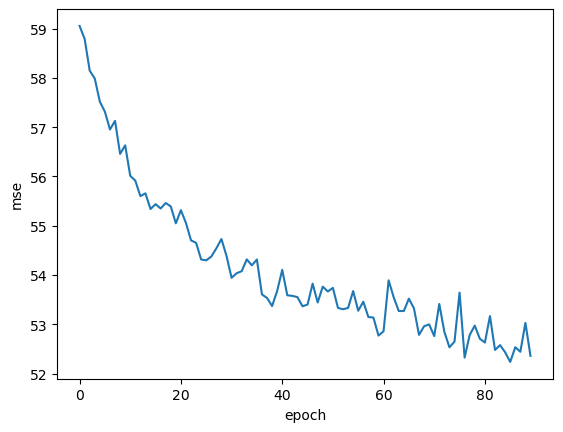

In [55]:
plt.plot(history.history["mse"][10:])
plt.gca().set(xlabel="epoch",ylabel="mse")
plt.show()

In [56]:
model.evaluate(X_test,y_test[:,:2],verbose=2)

53/53 - 0s - loss: 52.0611 - mae: 5.4923 - mse: 52.0611 - 164ms/epoch - 3ms/step


[52.06109619140625, 5.4922776222229, 52.06109619140625]

In [57]:
predictions = model.predict(X_test)

53/53 [==============================] - 0s 807us/step


In [58]:
predictions,y_test

(array([[-6.016826 , 62.21714  ],
        [ 9.212851 , 55.315018 ],
        [ 8.655206 , 49.96755  ],
        ...,
        [14.38587  , 48.665154 ],
        [-1.0201696, 62.50255  ],
        [-6.539229 , 54.085407 ]], dtype=float32),
 array([[-6.50000000e+00,  5.80000000e+01,  4.01282235e+08],
        [ 9.00000000e+00,  5.70000000e+01,  4.01121976e+08],
        [ 2.31250000e+01,  4.76250000e+01,  4.01112212e+08],
        ...,
        [ 1.95000000e+01,  4.77500000e+01,  4.01013040e+08],
        [-3.50000000e+00,  7.16250000e+01,  4.01301039e+08],
        [-1.82500000e+01,  4.63750000e+01,  4.01013045e+08]]))

In [59]:
sorted(zip(predictions, y_test[:,:2],np.array(y_test[:,2],dtype=int)), key=lambda x: x[2])

[(array([20.637564, 54.850285], dtype=float32),
  array([35.33333333, 54.25      ]),
  400603830),
 (array([ 5.434898, 56.452305], dtype=float32),
  array([ 3. , 64.5]),
  400603838),
 (array([ 8.069432, 45.898052], dtype=float32),
  array([ 2.83333333, 44.        ]),
  400603846),
 (array([-9.125129, 56.14583 ], dtype=float32),
  array([-23.66666667,  46.        ]),
  400603849),
 (array([14.03631, 72.36467], dtype=float32),
  array([ 9.83333333, 69.25      ]),
  400603851),
 (array([11.177268, 54.17163 ], dtype=float32),
  array([ 6.33333333, 50.        ]),
  400603854),
 (array([-2.9161208, 56.281273 ], dtype=float32),
  array([-2.5, 63.5]),
  400603868),
 (array([-5.905088, 47.14911 ], dtype=float32),
  array([-17.5 ,  48.25]),
  400603870),
 (array([14.444626, 55.85604 ], dtype=float32),
  array([14.83333333, 59.25      ]),
  400603876),
 (array([-5.6055236, 54.653374 ], dtype=float32),
  array([-6.5, 50.5]),
  400603878),
 (array([ 1.5590446, 60.872517 ], dtype=float32),
  array(

(array([ 15.,  42., 137., 275., 372., 385., 249., 134.,  55.,  13.]),
 array([-28.93836021, -22.07152748, -15.20469475,  -8.33786297,
         -1.47103   ,   5.3958025 ,  12.26263523,  19.12946701,
         25.99629974,  32.86313248,  39.72996521]),
 <BarContainer object of 10 artists>)

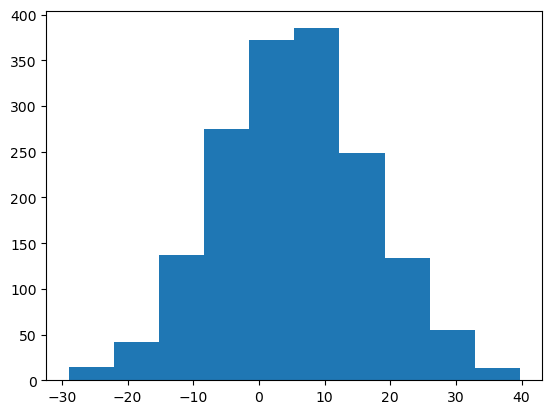

In [60]:
plt.hist(predictions[:,0])

In [61]:
list(zip(predictions[:10], X_test[:10,0]))[0]

(array([-6.016826, 62.21714 ], dtype=float32), 0.0)

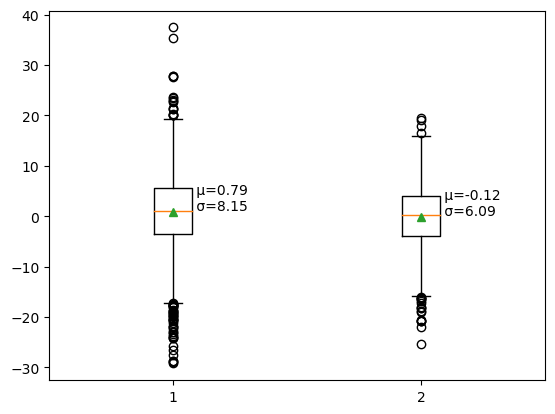

In [62]:
diff = predictions-y_test[:,:2]
diffmean = diff.mean(axis=0)
bestdiffstd = diff.std(axis=0)   #renamed variable so it's unique to this model
fig, ax = plt.subplots()
bp = ax.boxplot(diff,showmeans=True)
for i, line in enumerate(bp['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n σ={:.2f}'.format(diffmean[i], bestdiffstd[i])
    ax.annotate(text, xy=(x, y))
plt.show()

In [63]:
y_test

array([[-6.50000000e+00,  5.80000000e+01,  4.01282235e+08],
       [ 9.00000000e+00,  5.70000000e+01,  4.01121976e+08],
       [ 2.31250000e+01,  4.76250000e+01,  4.01112212e+08],
       ...,
       [ 1.95000000e+01,  4.77500000e+01,  4.01013040e+08],
       [-3.50000000e+00,  7.16250000e+01,  4.01301039e+08],
       [-1.82500000e+01,  4.63750000e+01,  4.01013045e+08]])

In [64]:
# model1spread = tf.keras.models.Sequential([
#     layers.Dense(100,input_shape=(X_train.shape[1],),activation='relu'),
#     layers.Dense(100,activation='relu'),
#     layers.Dense(1)
# ])

# model1pts = tf.keras.models.Sequential([
#     layers.Dense(100,input_shape=(X_train.shape[1],),activation='relu'),
#     layers.Dense(100,activation='relu'),
#     layers.Dense(1)
# ])

# model1spread.compile(optimizer='adam',
#                      loss='mse',
#                      metrics=['mae','mse'])
# model1pts.compile(optimizer='adam',
#                   loss='mse',
#                   metrics=['mae','mse'])

# history1spread = model1spread.fit(X_train,y_train[:,0],epochs=100,verbose=1)
# history1pts = model1pts.fit(X_train,y_train[:,1],epochs=100,verbose=1)



In [65]:
# plt.plot(history1spread.history["mse"][10:])
# plt.gca().set(xlabel="epoch",ylabel="mse")
# plt.title("Model for Point Spread in epoch=20-30")
# plt.ylabel("Mean Squared Error")
# plt.show()

In [66]:
# plt.plot(history1pts.history["mse"][10:])
# plt.gca().set(xlabel="epoch",ylabel="mse")
# plt.title("Model for Total Points in epoch=30-40")
# plt.ylabel("Mean Squared Error")
# plt.show()

In [67]:
# model1spread.evaluate(X_test,y_test[:,0],verbose=2)

In [68]:
# model1pts.evaluate(X_test,y_test[:,1],verbose=1)

In [69]:
# predictions1spread = model1spread.predict(X_test)
# predictions1pts = model1pts.predict(X_test)

In [70]:
# predictions1spread,y_test[:,0]

In [71]:
# predictions1spread.shape, y_test[:,0].shape

In [72]:
# diff = predictions1spread.flatten() - y_test[:,0]
# diffmean = diff.mean()
# diffstd = diff.std()
# fig, ax = plt.subplots()
# bp = ax.boxplot(diff)
# for i, line in enumerate(bp['medians']):
#     _x, _y = line.get_xydata()[1]
#     text = ' μ={:.2f}\n σ={:.2f}'.format(diffmean, diffstd)
#     plt.annotate(text, xy=(_x,_y))
# plt.show()

In [73]:
# diff = predictions1pts.flatten() - y_test[:,1]
# diffmean = diff.mean()
# diffstd = diff.std()
# fig, ax = plt.subplots()
# bp = ax.boxplot(diff)
# for i, line in enumerate(bp['medians']):
#     _x, _y = line.get_xydata()[1]
#     text = ' μ={:.2f}\n σ={:.2f}'.format(diffmean, diffstd)
#     plt.annotate(text, xy=(_x,_y))
# plt.show()

WORKING WITH AWAY AND HOME PTS

In [74]:
predict_scores_df=df_merged[['away_points', 'home_points','id']] #predictions using scores not betting lines

In [75]:
y_scores=np.array(predict_scores_df)  #use y_scores as y in model

In [76]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X,y_scores,test_size=0.3)  #haven't run model yet

#note: I don't see the need for validation dataset, we have a small sample size

In [77]:
# model2 = tf.keras.models.Sequential([
#     layers.Dense(100,input_shape=(X_train2.shape[1],),activation='relu'),
#     layers.Dense(100,activation='relu'),
#     layers.Dense(2)
# ])

In [78]:
# model2.summary()

In [79]:
# model2.compile(optimizer='adam',
#               loss='mse',
#               metrics=['mae','mse'])

In [80]:
# history = model2.fit(X_train2,y_train2[:,:2],epochs=100,verbose=1)

In [81]:
# model2.evaluate(X_test2,y_test2[:,:2],verbose=2)

In [82]:
# score_predictions=model2.predict(X_test2)

In [83]:
# score_predictions, y_test2

In [84]:
# diff = score_predictions-y_test2[:,:2]
# diffmean = diff.mean(axis=0)
# diffstd = diff.std(axis=0)
# fig, ax = plt.subplots()
# bp = ax.boxplot(diff,showmeans=True)
# for i, line in enumerate(bp['medians']):
#     x, y = line.get_xydata()[1]
#     text = ' μ={:.2f}\n σ={:.2f}'.format(diffmean[i], diffstd[i])
#     ax.annotate(text, xy=(x, y))
# plt.show()

In [85]:
# game_output=pd.DataFrame(score_predictions)
# game_output=game_output.rename(columns={0:'Predicted Away Score', 1:'Predicted Home Score'})
# game_output['Away Score']=predict_scores_df['away_points']
# game_output['Home Score']=predict_scores_df['home_points']
# game_output['Away Difference']=game_output['Predicted Away Score']-game_output['Away Score']
# game_output['Home Difference']=game_output['Predicted Home Score']-game_output['Home Score']
# game_output

In [86]:
# away_sd=np.std(game_output['Away Difference'])
# home_sd=np.std(game_output['Home Difference'])

# game_output['Adjusted Away Score']=np.rint(np.random.normal(game_output['Predicted Away Score'],away_sd))
# game_output['Adjusted Home Score']=np.rint(np.random.normal(game_output['Predicted Home Score'],home_sd))

In [87]:
# game_output

In [88]:
# #working with game spread and game avg
# predict_actual_line_df = df_merged[["game_spread","game_totalpts","id"]]

In [89]:
# X = np.array(parameters_df,dtype=np.float32)
# y_actual_lines = np.array(predict_actual_line_df)

# X_train3, X_test3, y_train3, y_test3 = train_test_split(X,y_actual_lines,test_size=0.2)

In [90]:
# model3 = tf.keras.models.Sequential([
#     layers.Dense(100,input_shape=(X_train3.shape[1],),activation='relu'),
#     layers.Dense(100,activation='relu'),
#     layers.Dense(2)
# ])

# model3.summary()

In [91]:
# model3.compile(optimizer='adam',
#                loss='mse',
#                metrics=['mae','mse'])

# history = model3.fit(X_train3,y_train3[:,:2],epochs=100,verbose=1)

In [92]:
# model3.evaluate(X_test3,y_test3[:,:2],verbose=2)

In [93]:
# actual_lines_predictions=model3.predict(X_test3)

In [94]:
# actual_lines_predictions, y_test3

In [95]:
# diff = actual_lines_predictions-y_test3[:,:2]
# diffmean = diff.mean(axis=0)
# diffstd = diff.std(axis=0)
# fig, ax = plt.subplots()
# bp = ax.boxplot(diff,showmeans=True)
# for i, line in enumerate(bp['medians']):
#     x, y = line.get_xydata()[1]
#     text = ' μ={:.2f}\n σ={:.2f}'.format(diffmean[i], diffstd[i])
#     ax.annotate(text, xy=(x, y))
# plt.show()

### Simulating Sample Game

In [96]:
#predict sample game
away_team='Alabama'
home_team='Auburn'
year=2018

In [97]:
cmd=\
f"""
SELECT *
FROM stats S
WHERE S.team='{home_team}' AND S.season={year}
"""

conn=sqlite3.connect("CollegeFootball.db")
df_predict1=pd.read_sql_query(cmd,conn)
conn.close() 

In [98]:
cmd=\
f"""
SELECT *
FROM stats S
WHERE S.team='{away_team}' AND S.season={year}
"""

conn=sqlite3.connect("CollegeFootball.db")
df_predict2=pd.read_sql_query(cmd,conn)
conn.close() 

In [99]:
df_predict=pd.concat([df_predict1,df_predict2])
df_predict=df_predict.reset_index(drop=True)
df_predict

,team,season,conference,Offensive_ppa,Offensive_success_rate,Offensive_explosiveness,Offensive_power_success,Offensive_stuff_rate,Offensive_line_yards,Defensive_ppa,...,Offensive_passing_plays_ppa,Offensive_passing_plays_success_rate,Offensive_passing_plays_explosiveness,Defensive_havoc_total,Defensive_rushing_plays_ppa,Defensive_rushing_plays_success_rate,Defensive_rushing_plays_explosiveness,Defensive_passing_plays_ppa,Defensive_passing_plays_success_rate,Defensive_passing_plays_explosiveness
0,Auburn,2018,SEC,0.168376,0.438538,1.162682,0.631579,0.187629,2.970722,0.074176,...,0.289142,0.412935,1.624326,0.191758,0.021383,0.372998,0.954062,0.135994,0.340708,1.738238
1,Alabama,2018,SEC,0.408224,0.543842,1.263771,0.752809,0.154955,3.414955,0.056770,...,0.639147,0.552809,1.761446,0.203967,0.056748,0.354701,1.070077,0.055218,0.343936,1.660669


In [100]:
df_predict=df_predict.loc[:, 'Offensive_ppa':]
df_predict

,Offensive_ppa,Offensive_success_rate,Offensive_explosiveness,Offensive_power_success,Offensive_stuff_rate,Offensive_line_yards,Defensive_ppa,Defensive_success_rate,Defensive_explosiveness,Defensive_power_success,...,Offensive_passing_plays_ppa,Offensive_passing_plays_success_rate,Offensive_passing_plays_explosiveness,Defensive_havoc_total,Defensive_rushing_plays_ppa,Defensive_rushing_plays_success_rate,Defensive_rushing_plays_explosiveness,Defensive_passing_plays_ppa,Defensive_passing_plays_success_rate,Defensive_passing_plays_explosiveness
0,0.168376,0.438538,1.162682,0.631579,0.187629,2.970722,0.074176,0.371429,1.242269,0.651163,...,0.289142,0.412935,1.624326,0.191758,0.021383,0.372998,0.954062,0.135994,0.340708,1.738238
1,0.408224,0.543842,1.263771,0.752809,0.154955,3.414955,0.056770,0.355036,1.348271,0.627451,...,0.639147,0.552809,1.761446,0.203967,0.056748,0.354701,1.070077,0.055218,0.343936,1.660669


In [101]:
var_array=np.array(0)  #account for not neutral site
var_array=np.append(var_array,np.array(df_predict,dtype=np.float32))
var_array=var_array.flatten()
var_array=var_array.reshape(1,53)
var_array

array([[0.        , 0.16837627, 0.43853819, 1.16268194, 0.63157892,
        0.18762887, 2.97072172, 0.07417581, 0.37142858, 1.24226904,
        0.6511628 , 0.23112129, 2.7839818 , 0.13289036, 0.07976601,
        0.44329897, 0.89116454, 0.2891418 , 0.41293532, 1.62432551,
        0.19175825, 0.02138349, 0.3729977 , 0.95406163, 0.13599364,
        0.34070796, 1.73823774, 0.40822443, 0.54384238, 1.26377141,
        0.75280899, 0.15495495, 3.4149549 , 0.0567697 , 0.3550356 ,
        1.34827077, 0.627451  , 0.20512821, 2.71004272, 0.10738916,
        0.24462704, 0.5243243 , 0.92827016, 0.63914651, 0.552809  ,
        1.76144564, 0.20396745, 0.05674806, 0.35470086, 1.0700773 ,
        0.05521759, 0.34393638, 1.66066933]])

In [102]:
prediction=model.predict(var_array)
prediction

1/1 [==============================] - 0s 16ms/step


array([[-10.639707,  57.093742]], dtype=float32)

In [103]:
pred=DataFunctions.prediction_to_score(prediction[0][0],prediction[0][1],bestdiffstd[0],bestdiffstd[1])
pred

'Away Points: 29, Home_Points: 32'

## Creating Alternative Pairing System

In [104]:
api_instance3 = cfbd.TeamsApi(cfbd.ApiClient(configuration))

In [105]:
team_locations=DataFunctions.get_team_locations(api_instance3,conferences)

In [106]:
team_locations=team_locations[team_locations.team != "Hawai'i"]
team_locations=team_locations[team_locations.team != "Jacksonville State"]
team_locations=team_locations[team_locations.team != "Sam Houston State"]
team_locations=team_locations.reset_index(drop=True)
team_locations

,team,id,latitude,longitude
0,Air Force,2005,38.996970,-104.843616
1,Akron,2006,41.072553,-81.508341
2,Alabama,333,33.208275,-87.550384
3,Appalachian State,2026,36.211427,-81.685428
4,Arizona,12,32.228805,-110.948868
...,...,...,...,...
125,Western Kentucky,98,36.984790,-86.459404
126,Western Michigan,2711,42.286006,-85.600757
127,West Virginia,277,39.650274,-79.955187
128,Wisconsin,275,43.069940,-89.412694


In [107]:
team_locations[team_locations["team"]=="Alabama"]

,team,id,latitude,longitude
2,Alabama,333,33.208275,-87.550384


In [108]:
set(team_locations["team"])

{'Air Force',
 'Akron',
 'Alabama',
 'Appalachian State',
 'Arizona',
 'Arizona State',
 'Arkansas',
 'Arkansas State',
 'Army',
 'Auburn',
 'BYU',
 'Ball State',
 'Baylor',
 'Boise State',
 'Boston College',
 'Bowling Green',
 'Buffalo',
 'California',
 'Central Michigan',
 'Charlotte',
 'Cincinnati',
 'Clemson',
 'Coastal Carolina',
 'Colorado',
 'Colorado State',
 'Connecticut',
 'Duke',
 'East Carolina',
 'Eastern Michigan',
 'Florida',
 'Florida Atlantic',
 'Florida International',
 'Florida State',
 'Fresno State',
 'Georgia',
 'Georgia Southern',
 'Georgia State',
 'Georgia Tech',
 'Houston',
 'Illinois',
 'Indiana',
 'Iowa',
 'Iowa State',
 'James Madison',
 'Kansas',
 'Kansas State',
 'Kent State',
 'Kentucky',
 'LSU',
 'Liberty',
 'Louisiana',
 'Louisiana Monroe',
 'Louisiana Tech',
 'Louisville',
 'Marshall',
 'Maryland',
 'Memphis',
 'Miami',
 'Miami (OH)',
 'Michigan',
 'Michigan State',
 'Middle Tennessee',
 'Minnesota',
 'Mississippi State',
 'Missouri',
 'NC State',
 'N

In [109]:
#   # how to get index of a specific team

# index=team_locations[team_locations['team']=='Alabama'].index
# index[0]

In [110]:
team_locations['latitude'][0]

38.9969701

In [111]:
# distances_array=np.zeros((len(team_locations),len(team_locations)))
# # removed bc distances=0 is no edge.
# # for i in range(distances_array.shape[0]):
# #     distances_array[i,i]=np.Infinity
# distances_array

In [112]:
#   #API Call

# for i in range(distances_array.shape[0]):
#     latitude_i=team_locations['latitude'][i]
#     longitude_i=team_locations['longitude'][i]
#     for j in range(i+1,distances_array.shape[0]):
#         latitude_j=team_locations['latitude'][j]
#         longitude_j=team_locations['longitude'][j]
#         url=f'http://dev.virtualearth.net/REST/V1/Routes?wp.0={latitude_i},{longitude_i}&wp.1={latitude_j},{longitude_j}&key=Aqi_rLZG4IuK6xhv3afUnfG36m98qTOEywzz5hDkbWM2rs8zA7FKGP3h8Zjm5SU7'
#         request = urllib.request.Request(url)
#         response = urllib.request.urlopen(request)
#         r = response.read().decode(encoding="utf-8")
#         result = json.loads(r)
#         distances_array[i,j]= result['resourceSets'][0]['resources'][0]['travelDuration']
#         distances_array[j,i]= distances_array[i,j]

In [113]:
# distances_array

In [114]:
# distances_df=pd.DataFrame(distances_array)
# distances_df

In [115]:
# conn = sqlite3.connect("CollegeFootball.db")
# distances_df.to_sql("distances",conn,if_exists="replace",index=False)

# conn.close()

In [116]:
# conn = sqlite3.connect("CollegeFootball.db")
# distances = pd.read_sql_query("SELECT * FROM distances",conn)

# conn.close()

# distances

In [117]:
# distances_array=np.array(distances)
# for i in range(distances_array.shape[0]):
#     for j in range(i+1,distances_array.shape[0]):
#         distances_array[i,j]=distances_array[i,j]/3600
#         distances_array[j,i]=distances_array[i,j]
        
# distances_df=pd.DataFrame(distances_array)
# distances_df

In [118]:
# conn = sqlite3.connect("CollegeFootball.db")
# distances_df.to_sql("distances",conn,if_exists="replace",index=False)

# conn.close()

In [119]:
conn = sqlite3.connect("CollegeFootball.db")
distances = pd.read_sql_query("SELECT * FROM distances",conn)

conn.close()

distances

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,0.000000,18.768889,18.059167,20.645556,11.290556,11.266389,10.980278,14.000833,25.148056,19.765278,...,21.718333,20.450556,21.376944,18.996389,16.578333,15.363333,15.908333,19.993056,13.922500,2.934167
1,18.768889,0.000000,10.334722,6.569444,27.659722,27.704444,12.506944,10.238056,6.508333,11.017500,...,6.343056,5.205278,6.131667,32.907500,30.186667,6.253889,4.042500,2.715278,7.173333,18.486944
2,18.059167,10.334722,0.000000,7.064444,20.666111,22.140278,7.771944,4.552778,14.962778,2.671944,...,9.436944,7.641667,7.374722,35.676389,32.955556,4.376111,10.627778,10.523889,11.779722,19.784722
3,20.645556,6.569444,7.064444,0.000000,26.890000,27.649722,12.239722,9.020556,9.865833,6.243611,...,4.340000,2.544722,1.598333,37.889167,35.168333,6.050278,10.140556,5.426944,12.155278,22.007222
4,11.290556,27.659722,20.666111,26.890000,0.000000,1.684167,16.571944,18.985278,34.053333,22.713611,...,29.253611,27.458056,27.738333,22.165833,20.551389,22.686389,25.758889,28.898056,24.628611,14.070278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,15.363333,6.253889,4.376111,6.050278,22.686389,23.459167,8.083611,4.830833,12.638611,5.548889,...,8.145278,6.628056,7.132500,32.585278,29.856667,0.000000,6.535833,6.921389,7.766944,16.734167
126,15.908333,4.042500,10.627778,10.140556,25.758889,25.787222,10.596944,8.707222,10.226389,11.800556,...,9.882500,8.753333,9.701667,29.808056,27.079444,6.535833,0.000000,6.359722,4.155556,15.425833
127,19.993056,2.715278,10.523889,5.426944,28.898056,28.926389,13.736111,10.941667,6.153056,10.535833,...,4.085278,4.039722,4.988056,35.175278,32.446667,6.921389,6.359722,0.000000,9.524722,20.838056
128,13.922500,7.173333,11.779722,12.155278,24.628611,24.656667,9.873611,8.546667,13.357222,12.952500,...,12.521111,11.237778,12.186111,26.112500,23.383889,7.766944,4.155556,9.524722,0.000000,13.431389


In [120]:
#saving model to use:
model.save("CFBprediction.h5")

In [121]:
import DataFunctions

In [135]:
m_dist = np.round(np.array(distances),decimals=3)
L = []
for k in range(130):
    for j in range(130):
        if k>j: L.append((k,j,m_dist[k,j]))
        
CollegeGraph = nx.Graph()
CollegeGraph.add_weighted_edges_from(L)
curr_data = np.zeros(shape=(130,3),dtype=int)
curr_data[:,0] = np.arange(130)

#ERROR: Says edge DNE even though it should.

# for i in range(10):
#     DataFunctions.Simulate(g=CollegeGraph,i=i,c=curr_data,y=2022,st_dev=bestdiffstd)

In [136]:
# #code deletes simul_games table, which includes all simulations
# conn = sqlite3.connect("CollegeFootball.db")
# cursor = conn.cursor()
# cursor.execute("DROP TABLE simul_games")
# conn.commit()
# conn.close()

In [137]:
len(CollegeGraph.edges.data("weight"))

8385

In [142]:
CollegeGraph.nodes()

130